# Your work here!

In [1]:
import numpy as np 
import pandas as pd
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

from nnViz_pytorch import *
import matplotlib.pylab as plt
plt.style.use(['Solarize_Light2'])
%matplotlib inline
!pwd
N = 96 
CPU = torch.device('cpu')
device = CPU

/home/irina/Hackathon/environmental-hackathon


In [55]:
model = torch.load("models/model_co2.v1.pth", map_location=device); model.eval()
model_co2 = model.float() 
model = torch.load("models/model_tem.v1.pth", map_location=device); model.eval()
model_tem = model.float() 
model = torch.load("models/model_dew.v1.pth", map_location=device); model.eval()
model_dew = model.float() 
model = torch.load("models/model_hum.v1.pth" , map_location=device); model.eval()
model_hum = model.float() 

1
12096


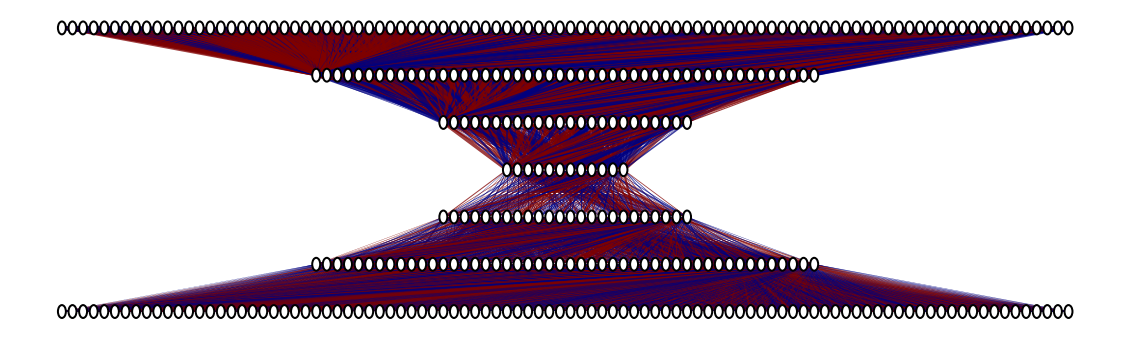

In [56]:
plt.figure(figsize=(20,6));
ax = plt.gca()
visualize_model(model_co2, ax)
plt.axis('tight'); plt.axis('off'); plt.show()

1
12096


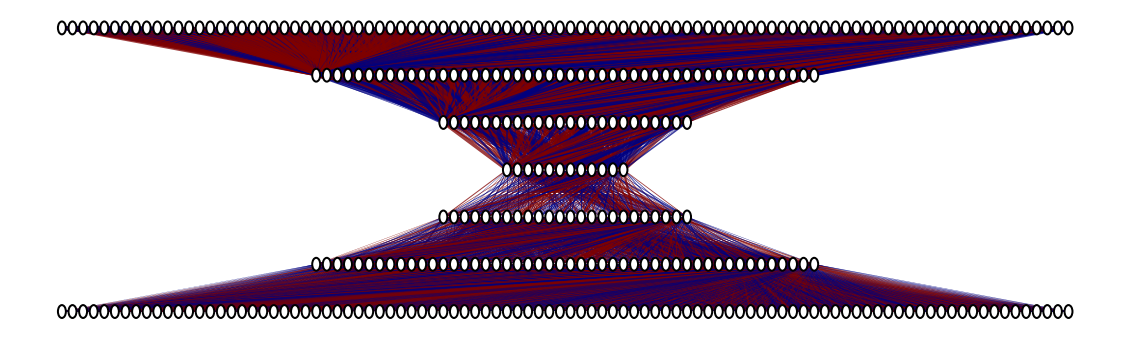

In [57]:
plt.figure(figsize=(20,6));
ax = plt.gca()
visualize_model(model_tem, ax)
plt.axis('tight'); plt.axis('off');
plt.show()

1
12096


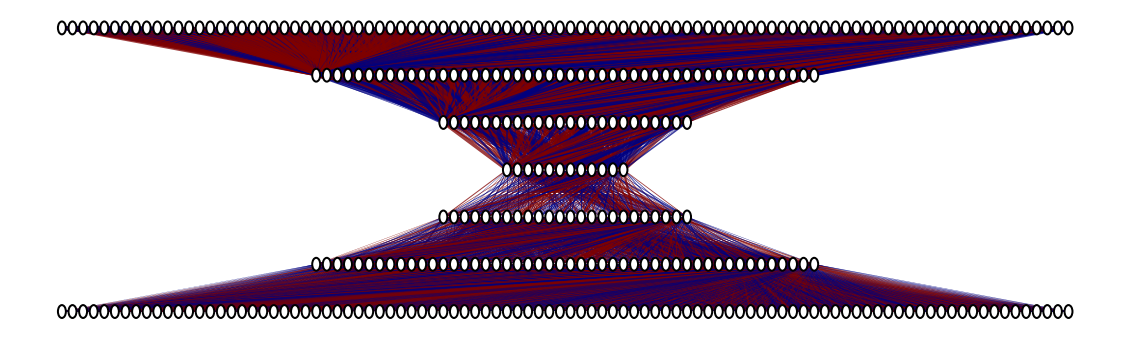

In [58]:
plt.figure(figsize=(20,6));
ax = plt.gca()
visualize_model(model_dew, ax)
plt.axis('tight'); plt.axis('off'); plt.show()


1
12096


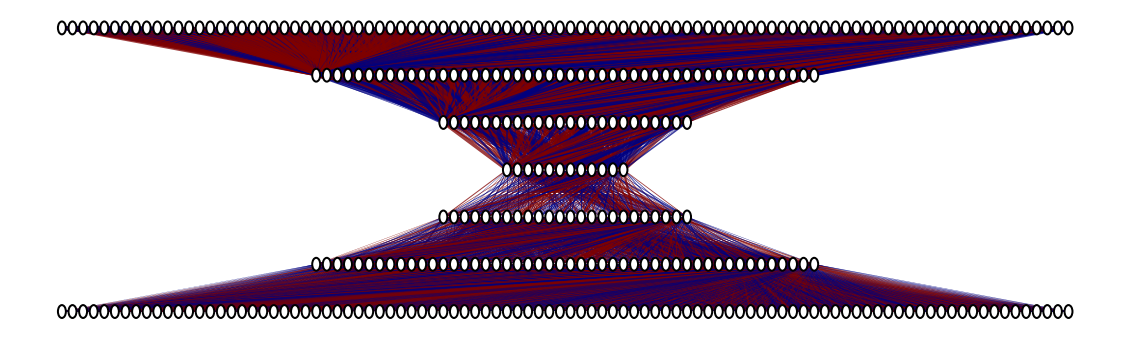

In [59]:
plt.figure(figsize=(20,6));
ax = plt.gca()
visualize_model(model_hum, ax)
plt.axis('tight'); plt.axis('off'); plt.show()

In [60]:
#test_red = np.load("data/test_data_reduced.npy")
test_red = np.load("data/train_data_reduced.npy")
test_red.shape

(20007, 960)

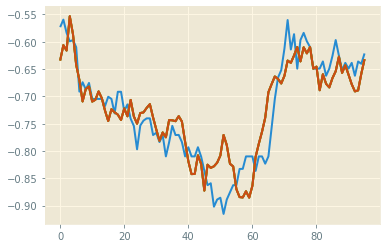

In [61]:
# check models for sanity:
s = test_red[10, :N]
v = torch.from_numpy(s).to(device)

p1 = model_co2.forward(v.float())
p2 = model_tem.forward(v.float())
p3 = model_dew.forward(v.float())
p4 = model_hum.forward(v.float())

plt.plot(v.numpy())
plt.plot(p1.data.cpu().numpy())
plt.plot(p2.data.cpu().numpy())
plt.plot(p3.data.cpu().numpy())
plt.plot(p4.data.cpu().numpy())

In [44]:
import copy
def predict_col(model, data):
    pred = copy.deepcopy(data)
    for i, d in enumerate(data):
        v = torch.from_numpy(d).to(CPU)
        p = model.forward(v.float())
        pred[i] = p.data.cpu().numpy()
    return pred    

def predict_all(models, data, debug=0):
    pred = copy.deepcopy(data)
    if debug:
        i = debug - 1
        m = models[i]
        d = data[:, i*N: (i+1)*N]
        p = predict_col(m, d)
        pred[:, i*N: (i+1)*N] = copy.copy(p)
        return pred  
    for i in range(len(models)):
        m = models[i]
        d = data[:, i*N: (i+1)*N]
        p = predict_col(m, d)
        pred[:, i*N: (i+1)*N] = copy.copy(p)
    return pred


In [45]:
models = [model_co2, model_tem, model_dew, model_hum]
train_pred = predict_all(models, test_red)

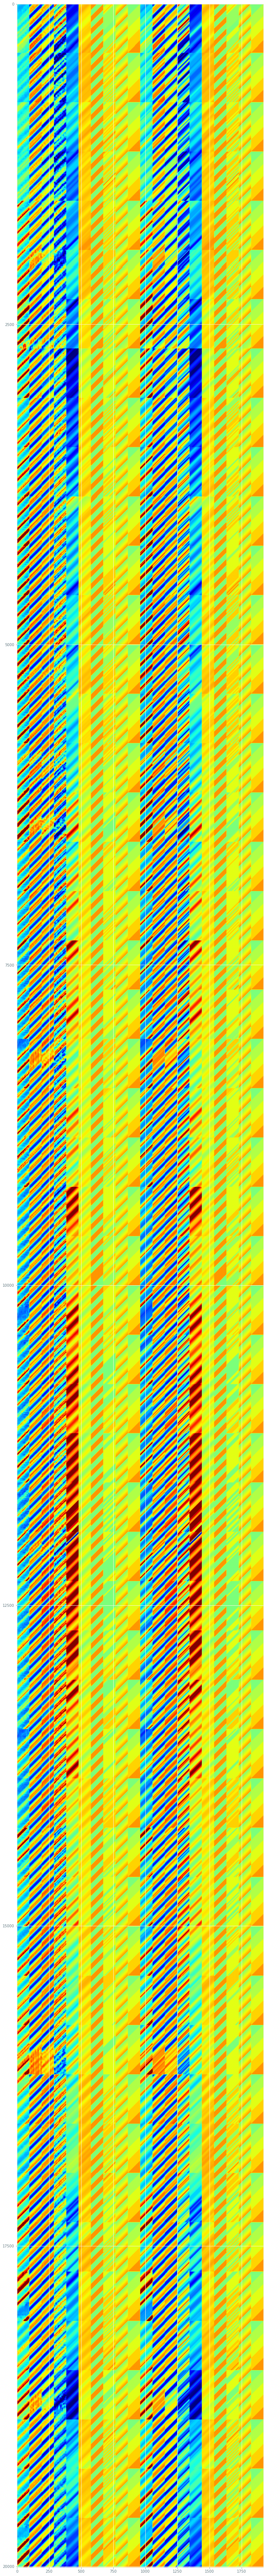

In [53]:
fig = plt.figure(figsize=(16,128))
plt.imshow(np.concatenate((train_pred,test_red),axis=1), cmap='jet', vmin=-2, vmax=2)

In [54]:
#np.save("data/train_pred_reduced.npy", train_pred)

In [9]:
def prediction_error(model, data):
    mse_errors = []
    
    for d in data:
        v = torch.from_numpy(d).to(CPU)
        p = model.forward(v.float())
        r = p.data.cpu().numpy()
        mse = (np.square(r - d)).mean(axis=None)
        mse_errors.append(mse) 
    return mse_errors          

In [10]:
def total_error( models, data, debug=0):
    mse = np.zeros(data.shape[0])
    if debug:
        i = debug - 1
        m = models[i]
        d = data[:, i*N: (i+1)*N]
        mse +=  prediction_error(m, d)
        return mse  
    for i in range(len(models)):
        m = models[i]
        d = data[:, i*N: (i+1)*N]
        mse +=  prediction_error(m, d)
    return mse


In [11]:
models = [model_co2, model_tem, model_dew, model_hum]
mse1 = total_error(models, test_red[:, :N*4], 1)
mse2 = total_error(models, test_red[:, :N*4], 2)
mse3 = total_error(models, test_red[:, :N*4], 3)
mse4 = total_error(models, test_red[:, :N*4], 4)

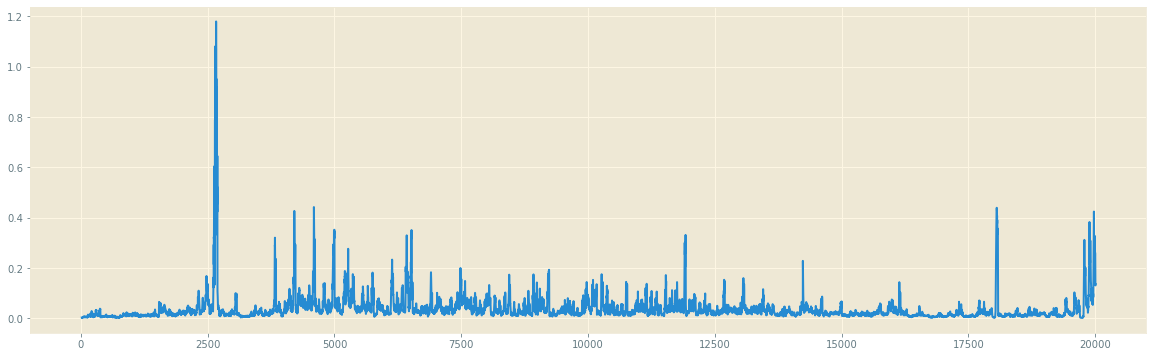

In [12]:
plt.figure(figsize=(20,6));
plt.plot(mse1)

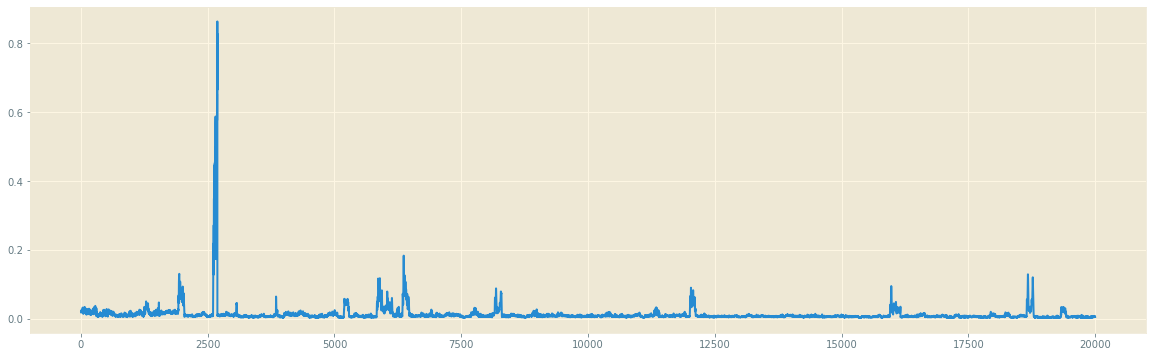

In [13]:
plt.figure(figsize=(20,6));
plt.plot(mse2)

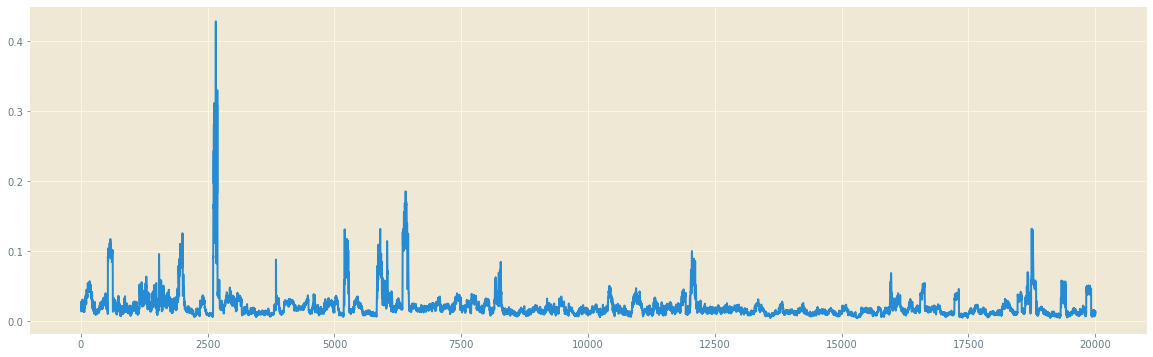

In [14]:
plt.figure(figsize=(20,6));
plt.plot(mse3)

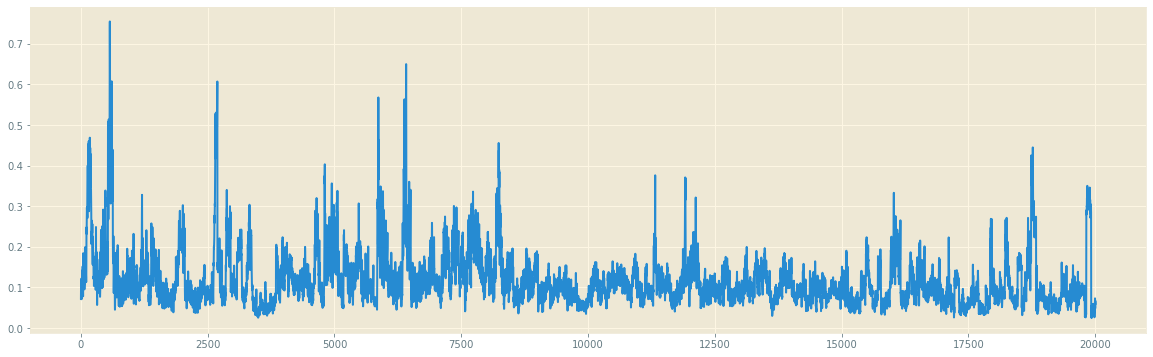

In [15]:
plt.figure(figsize=(20,6));
plt.plot(mse4)

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


<AxesSubplot:>

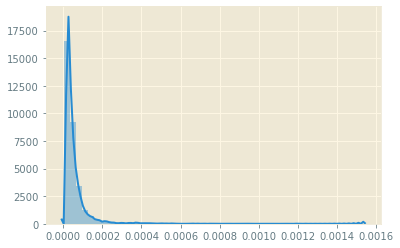

In [17]:
sns.distplot(mse1/sum(mse1))

<AxesSubplot:>

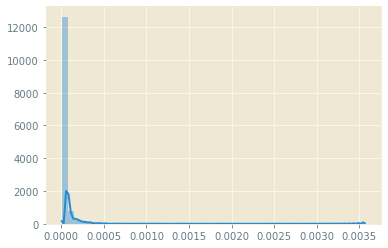

In [18]:
sns.distplot(mse2/sum(mse2))

<AxesSubplot:>

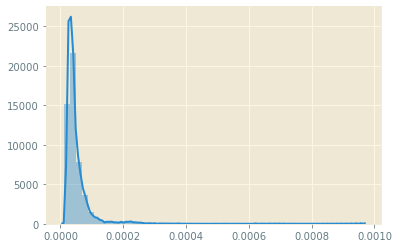

In [19]:
sns.distplot(mse3/sum(mse3))

<AxesSubplot:>

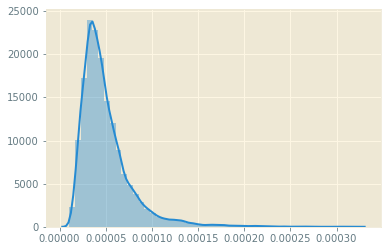

In [20]:
sns.distplot(mse4/sum(mse4))


In [21]:
print(sum(mse1), sum(mse2), sum(mse3), sum(mse4))

768.3873935114779 242.21426318546196 444.6367367569568 2338.573156171701


<AxesSubplot:>

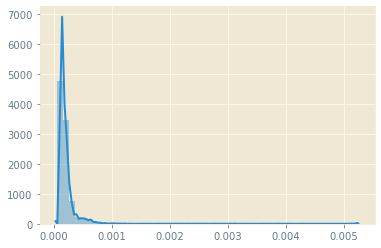

In [22]:
mse = mse1/sum(mse1) + mse2/sum(mse2) + mse3/sum(mse3) + mse4/sum(mse4) 
sns.distplot(mse)

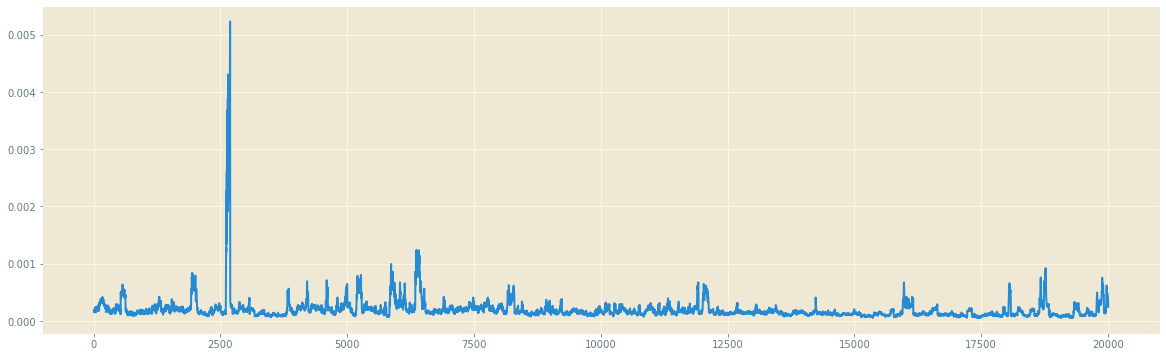

In [23]:
plt.figure(figsize=(20,6)); 
plt.plot(mse)

In [24]:
def thrcurve(err):
    n_outliers = []
    thresholds = []
    n = 100
    maxe = max(err)
    mine = sum(err)/len(err)
    for i in reversed(range(n)):
        th = mine + i *(maxe-mine)/n
        a = len([e for e in err if e >th])
        if a > 300:
            mine = th
            break
    for i in range(n):
        th = mine + i *(maxe-mine)/n
        n_outliers.append(len([e for e in err if e >th]))
        thresholds.append(th) 
    return thresholds, n_outliers

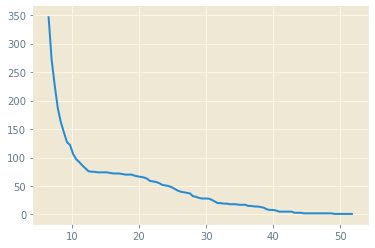

In [25]:
thresholds, outliers = thrcurve(mse*10000)
plt.plot(thresholds, outliers)

In [26]:
th = 0.0015
anom = [i for i, e in enumerate(mse) if e >th]
print(anom, len(anom))


[2615, 2617, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690] 74


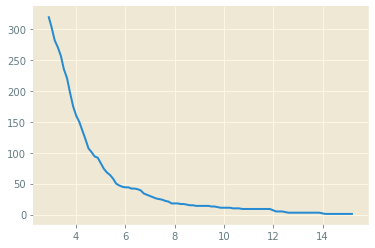

In [27]:
thresholds, outliers = thrcurve(mse1/sum(mse1)*10000)
plt.plot(thresholds, outliers)

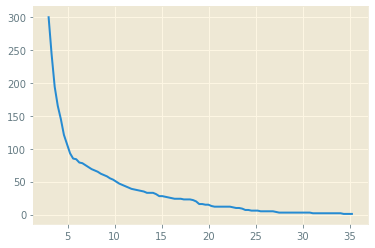

In [28]:
thresholds, outliers = thrcurve(mse2/sum(mse2)*10000)
plt.plot(thresholds, outliers)

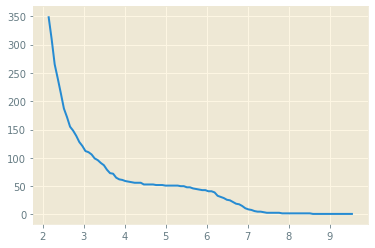

In [29]:
thresholds, outliers = thrcurve(mse3/sum(mse3)*10000)
plt.plot(thresholds, outliers)

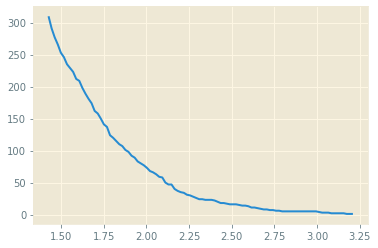

In [30]:
thresholds, outliers = thrcurve(mse4/sum(mse4)*10000)
plt.plot(thresholds, outliers)

In [31]:
train_hum = train_red[:, N*3: N*4]
test_hum  = test_red[:,  N*3: N*4]
DL_Train_hum = DataLoader(train_hum.astype('float32'), batch_size=16, shuffle = True )
DL_Test_hum  = DataLoader( test_hum.astype('float32'), batch_size=1 , shuffle = False )
#model_hum, loss_hum = train_model( model, DL_Train_hum, targetDevice, nEpochs)
model_hum, loss_hum = train_model( model_hum, DL_Train_hum, targetDevice, nEpochs)

DL_Train_hum2 = DataLoader(test_hum.astype('float32'), batch_size=16, shuffle = True )
model_hum, loss_hum = train_model( model_hum, DL_Train_hum2, targetDevice, 20) 
torch.save( model_hum, "model_hum.v1.pth")


NameError: name 'train_red' is not defined

In [ ]:
plt.figure(figsize=(6,6));
plt.plot(loss_hum)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');


In [ ]:
mse_errors_hum = evaluate_model( model_hum, DL_Test_hum, targetDeviceGPU, len(test_red))
print(len(mse_errors_hum))
plt.figure(figsize=(16,6));
plt.plot(mse_errors_hum)